In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import cv2
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageEnhance
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import os
from scipy import stats
from scipy.spatial import distance

In [2]:
# import zipfile
# with zipfile.ZipFile("full_data_v5.zip", 'r') as zip_ref:
#     zip_ref.extractall("full_data_v5")

In [3]:
# Ignore Label Parts, that's for another experiments

# Normalization and Standardization
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

def standardize(data):
    return (data - np.mean(data)) / np.std(data)

# Get data from path
def get_data(ct_path, pet_path, mask_path, label_path):
    Y = list()
    X = list()
    Labels = list()
    masks = np.load(mask_path, allow_pickle=True)
    ct = np.load(ct_path, allow_pickle=True)
    pet = np.load(pet_path, allow_pickle=True)
    label = np.load(label_path, allow_pickle=True)
    for i in range(len(masks)):
        Y_sub = []
        X_sub = []
        label_sub = []
        for j in range(len(masks[i])):
            masks[i][j] = cv2.resize(masks[i][j].astype('float32'),(128,128))
            ct[i][j] = cv2.resize(ct[i][j].astype('float32'),(128,128))
            pet[i][j] = cv2.resize(pet[i][j].astype('float32'),(128,128))
            masks[i][j][masks[i][j]>0] = 1
            masks[i][j][masks[i][j]<0] = 0
            Y_sub.append(masks[i][j])
            label_sub.append(label[i])
            X_sub.append([standardize(ct[i][j]), standardize(pet[i][j])])
        X.append(X_sub)
        Y.append(Y_sub)
        Labels.append(label_sub)
    return  X, Y, Labels

# Data augmentation
def augment(x, y, label):
    aug_ct = list()
    aug_pet = list ()
    aug_y = list()
    aug_label = list()
    for n_mask, n_image, l in zip(y, x, label):
        ct_img = n_image[0]
        pet_img = n_image[1]
        ct_img = Image.fromarray(normalization(ct_img).astype('float32'))
        pet_img = Image.fromarray(normalization(pet_img).astype('float32'))
        mask = Image.fromarray(n_mask.astype('float32'))
        if random.random() > 0.3:
            horizontal = transforms.RandomHorizontalFlip(p=1)
            aug_y.append(np.array(horizontal(mask)))
            aug_ct.append(standardize(np.array(horizontal(ct_img))))
            aug_pet.append(standardize(np.array(horizontal(pet_img))))
            if l == 3:
                aug_label.append(10)
            elif l == 4:
                aug_label.append(11)
            elif l == 9:
                aug_label.append(14)
            elif l == 8:
                aug_label.append(16)
            elif l == 10:
                aug_label.append(3)
            elif l == 11:
                aug_label.append(4)
            elif l == 14:
                aug_label.append(9)
            elif l == 16:
                aug_label.append(8)
            else:
                aug_label.append(l)
        if random.random() > 0.8:
            vertical = transforms.RandomVerticalFlip(p=1)
            aug_y.append(np.array(vertical(mask)))
            aug_ct.append(standardize(np.array(vertical(ct_img))))
            aug_label.append(l)
            aug_pet.append(standardize(np.array(vertical(pet_img))))
        if random.random() > 0.3:
            angle = transforms.RandomRotation.get_params([-30, 30])
            aug_y.append(np.array(mask.rotate(angle)))
            aug_ct.append(standardize(np.array(ct_img.rotate(angle))))
            aug_pet.append(standardize(np.array(pet_img.rotate(angle))))
            aug_label.append(l)
        if random.random() > 0.3:
            crop_win_size = np.random.randint(100, 160)
            random_region = (
                    (128 - crop_win_size) >> 1, (128 - crop_win_size) >> 1, (128 + crop_win_size) >> 1,
                    (128 + crop_win_size) >> 1)
            cropped_mask = cv2.resize(np.array(mask.crop(random_region)),(128,128))
            cropped_ct_img = cv2.resize(np.array(ct_img.crop(random_region)),(128,128))
            cropped_pet_img = cv2.resize(np.array(pet_img.crop(random_region)),(128,128))
            aug_y.append(cropped_mask)
            aug_label.append(l)
            aug_ct.append(standardize(cropped_ct_img))
            aug_pet.append(standardize(cropped_pet_img))
    result_x, result_y, result_label = np.stack((np.array(aug_ct),np.array(aug_pet)),1), np.array(aug_y), np.array(aug_label)
    x = np.concatenate((x, result_x))
    y = np.concatenate((y, result_y))
    label = np.concatenate((label, result_label))
    return [x, y, label]

def flatten(array):
    return_array = []
    for i in range(len(array)):
        return_array += array[i]
    return np.array(return_array)

# Convert to K-Folds
def K_Folds(X, Y, Labels):
    fx_1 = X[0:11]
    fy_1 = Y[0:11]
    fl_1 = Labels[0:11]
    fx_2 = X[11:21]
    fy_2 = Y[11:21]
    fl_2 = Labels[11:21]
    fx_3 = X[21:31]
    fy_3 = Y[21:31]
    fl_3 = Labels[21:31]
    fx_4 = X[31:41]
    fy_4 = Y[31:41]
    fl_4 = Labels[31:41]
    fx_5 = X[41:51]
    fy_5 = Y[41:51]
    fl_5 = Labels[41:51]
    fold_1_train = augment(flatten(fx_2+fx_3+fx_4+fx_5), flatten(fy_2+fy_3+fy_4+fy_5), flatten(fl_2+fl_3+fl_4+fl_5))
    fold_1_test = [flatten(fx_1), flatten(fy_1), flatten(fl_1)]
    fold_2_train = augment(flatten(fx_1+fx_3+fx_4+fx_5), flatten(fy_1+fy_3+fy_4+fy_5), flatten(fl_1+fl_3+fl_4+fl_5))
    fold_2_test = [flatten(fx_2), flatten(fy_2), flatten(fl_2)]
    fold_3_train = augment(flatten(fx_1+fx_2+fx_4+fx_5), flatten(fy_1+fy_2+fy_4+fy_5), flatten(fl_1+fl_2+fl_4+fl_5))
    fold_3_test = [flatten(fx_3), flatten(fy_3), flatten(fl_3)]
    fold_4_train = augment(flatten(fx_1+fx_2+fx_3+fx_5), flatten(fy_1+fy_2+fy_3+fy_5), flatten(fl_1+fl_2+fl_3+fl_5))
    fold_4_test = [flatten(fx_4), flatten(fy_4), flatten(fl_4)]
    fold_5_train = augment(flatten(fx_1+fx_2+fx_3+fx_4), flatten(fy_1+fy_2+fy_3+fy_4), flatten(fl_1+fl_2+fl_3+fl_4))
    fold_5_test = [flatten(fx_5), flatten(fy_5), flatten(fl_5)]
    
    return [fold_1_train, fold_2_train, fold_3_train, fold_4_train, fold_5_train], [fold_1_test, fold_2_test, fold_3_test, fold_4_test, fold_5_test]

class CT_PET_Data(Dataset):
    def __init__(self,X_data,Y_data,label_data):
        self.features = X_data
        self.targets = Y_data
        self.labels = label_data
    def __getitem__(self, index):
        X = self.features[index]
        Y = self.targets[index].reshape(1,128,128)
        CT = X[0].reshape(1,128,128)
        PET = X[1].reshape(1,128,128)
        L = self.labels[index]
        return (CT, PET), Y, L
    
    def __len__(self):
        return len(self.features)

In [5]:
# Load data
data = np.load('label_data.npz', allow_pickle=True)
data_train = data["train"]
data_test = data["test"]

In [6]:
# Loss functions and evaluations
def BCE_dice_loss(inputs, targets):
    bce_loss = FocalLoss()
    return bce_loss(inputs, targets)


class FocalLoss(nn.Module):
    def __init__(self, alpha=.75, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        
    def forward(self, inputs, targets):
        batch, channel, height, width = targets.shape
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        at = targets.clone()
        pt = torch.exp(-BCE_loss)    
        F_loss = (at * self.alpha + (1-at) * (1-self.alpha)) *(1-pt)**self.gamma * BCE_loss
        if self.reduce:
            return torch.mean(torch.mean(F_loss.reshape(batch, height*width), 1))
        else:
            return F_loss

In [7]:
# Feature modality classifier
class class_block(nn.Module):
    def __init__(self, channel, spatial_size):
        super().__init__()
        self.channel = channel
        self.conv = nn.Sequential(
            nn.Conv2d(64, self.channel, 1),  
            nn.BatchNorm2d(self.channel)
        )
        
        in_channel = self.channel*spatial_size
        
        self.predict = nn.Sequential(
            nn.Linear(in_channel, in_channel//4),
            nn.BatchNorm1d(in_channel//4),
            nn.LeakyReLU(0.1),
            nn.Linear(in_channel//4, in_channel//16),
            nn.BatchNorm1d(in_channel//16),
            nn.LeakyReLU(0.1),
            nn.Linear(in_channel//16, in_channel//64),
            nn.BatchNorm1d(in_channel//64),
            nn.LeakyReLU(0.1),
            nn.Linear(in_channel//64, 1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        if self.channel != 64:
            x = self.conv(x)
        
        x = x.view(x.size(0), -1)
        out = self.predict(x)
        return out

class feature_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_4 = class_block(64, 8*8)
        self.block_3 = class_block(16, 16*16)
        self.block_2 = class_block(4, 32*32)
        self.block_1 = class_block(1, 64*64)
    def forward(self, x):
        ct_1, pet_1, ct_2, pet_2, ct_3, pet_3 ,ct_4, pet_4 = x
        
        return [self.block_4(ct_4.detach()), self.block_4(pet_4.detach()), 
                self.block_3(ct_3.detach()), self.block_3(pet_3.detach()),
                self.block_2(ct_2.detach()), self.block_2(pet_2.detach()),
                self.block_1(ct_1.detach()), self.block_1(pet_1.detach())]
    
        
def label_loss(feature, PET_L, CT_L):
    ct_1, pet_1, ct_2, pet_2, ct_3, pet_3 ,ct_4, pet_4 = feature
    pet_loss = nn.BCELoss()
    ct_loss = nn.BCELoss()
    l = pet_loss(pet_1, PET_L) + ct_loss(ct_1, CT_L) + pet_loss(pet_2, PET_L) + ct_loss(ct_2, CT_L) +pet_loss(pet_3, PET_L) + ct_loss(ct_3, CT_L) + pet_loss(pet_4, PET_L) + ct_loss(ct_4, CT_L)
    return 0.125*l

In [8]:
# Model
class encoder_block(nn.Module):    
    def __init__(self, in_channels, out_channels, conv_kernel=3, pool_kernel=2, pool_stride=2, relu_leakiness=0.1):
        super().__init__()
        conv_pad = 1
        conv1 = nn.Conv2d(in_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)
        conv2 = nn.Conv2d(out_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)
        leaky_relu = nn.LeakyReLU(negative_slope = relu_leakiness, inplace=False)
        batch_norm = nn.BatchNorm2d(out_channels, eps=1e-03, momentum=0.9, affine=True, track_running_stats=True)

        self.max_pool = nn.MaxPool2d(pool_kernel, stride=pool_stride)       
        self.encoder = nn.Sequential(
                            conv1,
                            leaky_relu,
                            batch_norm,
                            conv2,
                            leaky_relu,
                            batch_norm,
                            )
        
    def forward(self, x):
        
        out = self.encoder(x)
        out= self.max_pool(out)
        return out

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel=3, relu_leakiness=0.1):
        super().__init__()
        conv_pad = 1
        conv1 = nn.Conv2d(out_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1) 
        leaky_relu = nn.LeakyReLU(negative_slope = relu_leakiness, inplace=False)
        batch_norm = nn.BatchNorm2d(out_channels, eps=1e-03, momentum=0.9, affine=True, track_running_stats=True)
        conv2 = nn.Conv2d(out_channels, out_channels, 
                          kernel_size = conv_kernel, padding= conv_pad)

        self.decoder = nn.Sequential( 
                            conv1,
                            leaky_relu,
                            batch_norm,
                            conv2,
                            leaky_relu,
                            batch_norm)

        
    def forward(self, x):
        out = self.upsample(x)
        out = self.decoder(out)
        return out
        
            
class FuseNet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.ct_encoder1 = encoder_block(1, 64)
        self.ct_encoder2 = encoder_block(64, 64)
        self.ct_encoder3 = encoder_block(64, 64)
        self.ct_encoder4 = encoder_block(64, 64)
        self.max_pool = nn.MaxPool2d(2, 2)     
        
        self.pet_encoder1 = encoder_block(1, 64)
        self.pet_encoder2 = encoder_block(64, 64)
        self.pet_encoder3 = encoder_block(64, 64) 
        self.pet_encoder4 = encoder_block(64, 64)
        self.fuse_1 = _3D_Conv()
        self.fuse_2 = _3D_Conv()
        self.fuse_3 = _3D_Conv()
        self.fuse_4 = _3D_Conv()

        self.decoder1 = decoder_block(128, 64)
        self.decoder2 = decoder_block(192, 64)
        self.decoder3 = decoder_block(192, 64)
        self.decoder4 = decoder_block(192, 64)
        
        self.label_decoder1 = decoder_block(128, 64)
        self.label_decoder2 = decoder_block(192, 64)
        self.label_decoder3 = decoder_block(192, 64)
        self.label_decoder4 = decoder_block(192, 64)
        self.Sigmoid = nn.Sigmoid() 
        self.output_layer_ct = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid())
        self.output_layer_pet = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid())
        self.output_layer_co =  nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid())

    def forward(self, x):
        ct_input, pet_input = x
        ct_input = Variable(ct_input.type(torch.FloatTensor)).to(self.device)
        pet_input = Variable(pet_input.type(torch.FloatTensor)).to(self.device)
    
        ct_1 = self.ct_encoder1(ct_input)
        pet_1 = self.pet_encoder1(pet_input)  
        fusion_4 = self.fuse_1(ct_1, pet_1)
        
        ct_2 = self.ct_encoder2(ct_1)
        pet_2 = self.pet_encoder2(pet_1)
        fusion_3 = self.fuse_2(ct_2, pet_2)
        
        ct_3 = self.ct_encoder3(ct_2)
        pet_3 = self.pet_encoder3(pet_2)
        fusion_2 = self.fuse_3(ct_3, pet_3)
        
        ct_4 = self.ct_encoder4(ct_3)
        pet_4 = self.pet_encoder4(pet_3)     
        fusion_1 = self.fuse_4(ct_4, pet_4)
        
        output_1 = self.decoder1(fusion_1)

        fusion_2 = torch.cat((fusion_2, output_1),1)
        output_2 = self.decoder2(fusion_2)

        fusion_3 = torch.cat((fusion_3, output_2),1)
        output_3 = self.decoder3(fusion_3)

        fusion_4 = torch.cat((fusion_4, output_3),1)
        output_4 = self.decoder4(fusion_4)
        co_output = self.output_layer_co(output_4)
        return co_output, [ct_1, pet_1, ct_2, pet_2, ct_3, pet_3 ,ct_4, pet_4]

In [21]:

# Training and evaluation
def fit(model, loader_train, loader_val, loss_fn, optimizer, num_epochs, model_class, loss_class, optimizer_class, schedul = False):
    val_list = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if schedul:
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience = 10)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for i, (data, target, label) in enumerate(loader_train):
#             model_class.eval()
            target =  Variable(target.type(torch.FloatTensor)).to(device)
#             label =  Variable(label.type(torch.LongTensor)).to(device)
            scores_co, PET_CT = model(data)
            
            Labels = model_class(PET_CT)
            D_PET = torch.ones([5,1]).to(device)
            D_CT = torch.zeros([5,1]).to(device)
            loss = loss_fn(scores_co, target) -0.1*(loss_class(Labels, D_PET, D_CT).detach())
            
            epoch_loss += loss
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i%5 == 0:
                new_loss = -loss_fn(scores_co, target).detach() +0.1*loss_class(Labels, D_PET, D_CT)
                new_loss.backward()
                optimizer_class.step()
                
        if (epoch+1) % 5 == 0:
            val_dice = check_val(model, loader_val)
            val_list.append(val_dice)
            print("Epoch ", epoch+1, " ends : ", "Avg Train Loss = %.4f" % (epoch_loss/i), "; Avg test Dice = %.4f" % (val_dice))
        if schedul:
            scheduler.step(epoch_loss/i)    
    return np.array(val_list)[-1]

def check_val(model, loader):
    val_list = []
    with torch.no_grad():
        for i, (data, target, label) in enumerate(loader):
            outputs,_  = model(data)
            assert outputs.shape == target.shape
            for j in range(len(target)):
                predict = outputs[j].cpu().numpy().reshape(128,128).copy()*255
                mask = target[j].reshape(128, 128).data.numpy().copy()   
                _, predict = cv2.threshold(predict.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                val_list.append(1-distance.dice(predict.flatten()/255, mask.flatten()))    
    return np.array(val_list).mean()

def generate_loader(x_train, y_train, l_train, x_test, y_test, l_test,  batches = 64):
    loader_train = DataLoader(CT_PET_Data(x_train, y_train, l_train), batch_size=batches, num_workers=8, shuffle=True, drop_last=True)
    loader_test = DataLoader(CT_PET_Data(x_test, y_test, l_test), batch_size=batches, num_workers=8, shuffle=False,drop_last=False)
    return loader_train, loader_test

def cross_validation(train_data, test_data, k, batch_size, lr, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_val = []
    for use_fold_idx in [0,1,2,3,4]:
        X_Train, Y_Train, L_Train = train_data[use_fold_idx][0], train_data[use_fold_idx][1],  train_data[use_fold_idx][2]
        X_Test, Y_Test, L_Test = test_data[use_fold_idx][0],test_data[use_fold_idx][1],  test_data[use_fold_idx][2]
        loader_train, loader_test = generate_loader(X_Train, Y_Train,L_Train, X_Test, Y_Test,L_Test,  batch_size)
        model = torch.nn.DataParallel(FuseNet(), device_ids=[0,1])
        model = model.to(device)
        
        d = torch.nn.DataParallel(feature_classifier(), device_ids=[0,1])
        d = d.to(device)
        
        optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
        optimizer_d = torch.optim.Adamax(d.parameters(), lr = 1e-4)
        
        result = fit(model, loader_train, loader_test, BCE_dice_loss, optimizer, num_epochs, d, label_loss, optimizer_d, False)
        print("Fold "+str(use_fold_idx)+": result: %.4f" % (result))
        print("------------------------------------------------")
        test_val.append(result)
#         del model
    final_result = np.array(test_val).mean()
    print("Cross Validation result: %.4f" % (final_result))
    return final_result, loader_test, model
# 0.6268, 0.6070, 0.6721, 0.6570

In [14]:
final_result = cross_validation(data_train, data_test, 5, 5, 1e-4, 40)

Epoch  5  ends :  Avg Train Loss = -0.0783 ; Avg test Dice = 0.5729
Epoch  10  ends :  Avg Train Loss = -0.0769 ; Avg test Dice = 0.5975
Epoch  15  ends :  Avg Train Loss = -0.0753 ; Avg test Dice = 0.5906
Epoch  20  ends :  Avg Train Loss = -0.0738 ; Avg test Dice = 0.5990
Epoch  25  ends :  Avg Train Loss = -0.0725 ; Avg test Dice = 0.5884
Epoch  30  ends :  Avg Train Loss = -0.0714 ; Avg test Dice = 0.6137
Epoch  35  ends :  Avg Train Loss = -0.0705 ; Avg test Dice = 0.6074
Epoch  40  ends :  Avg Train Loss = -0.0699 ; Avg test Dice = 0.6121
Fold 0: result: 0.6121
------------------------------------------------
Epoch  5  ends :  Avg Train Loss = -0.0781 ; Avg test Dice = 0.6216
Epoch  10  ends :  Avg Train Loss = -0.0769 ; Avg test Dice = 0.6435
Epoch  15  ends :  Avg Train Loss = -0.0753 ; Avg test Dice = 0.6412
Epoch  20  ends :  Avg Train Loss = -0.0738 ; Avg test Dice = 0.6365
Epoch  25  ends :  Avg Train Loss = -0.0725 ; Avg test Dice = 0.6535
Epoch  30  ends :  Avg Train Loss

In [15]:
final_result = cross_validation(data_train, data_test, 5, 5, 1e-4, 40)

Epoch  5  ends :  Avg Train Loss = -0.0761 ; Avg test Dice = 0.4818
Epoch  10  ends :  Avg Train Loss = -0.0759 ; Avg test Dice = 0.5134
Epoch  15  ends :  Avg Train Loss = -0.0746 ; Avg test Dice = 0.5038
Epoch  20  ends :  Avg Train Loss = -0.0733 ; Avg test Dice = 0.5062
Epoch  25  ends :  Avg Train Loss = -0.0722 ; Avg test Dice = 0.5609
Epoch  30  ends :  Avg Train Loss = -0.0712 ; Avg test Dice = 0.5614
Epoch  35  ends :  Avg Train Loss = -0.0704 ; Avg test Dice = 0.5461
Epoch  40  ends :  Avg Train Loss = -0.0697 ; Avg test Dice = 0.5690
Fold 0: result: 0.5690
------------------------------------------------
Epoch  5  ends :  Avg Train Loss = -0.0782 ; Avg test Dice = 0.6237
Epoch  10  ends :  Avg Train Loss = -0.0769 ; Avg test Dice = 0.6433
Epoch  15  ends :  Avg Train Loss = -0.0753 ; Avg test Dice = 0.6405
Epoch  20  ends :  Avg Train Loss = -0.0738 ; Avg test Dice = 0.6424
Epoch  25  ends :  Avg Train Loss = -0.0726 ; Avg test Dice = 0.6380
Epoch  30  ends :  Avg Train Loss

In [17]:
final_result = cross_validation(data_train, data_test, 5, 5, 1e-4, 40)

Epoch  5  ends :  Avg Train Loss = -0.0782 ; Avg test Dice = 0.5286
Epoch  10  ends :  Avg Train Loss = -0.0768 ; Avg test Dice = 0.5623
Epoch  15  ends :  Avg Train Loss = -0.0753 ; Avg test Dice = 0.5779
Epoch  20  ends :  Avg Train Loss = -0.0738 ; Avg test Dice = 0.5926
Epoch  25  ends :  Avg Train Loss = -0.0725 ; Avg test Dice = 0.6009
Epoch  30  ends :  Avg Train Loss = -0.0714 ; Avg test Dice = 0.6045
Epoch  35  ends :  Avg Train Loss = -0.0705 ; Avg test Dice = 0.6061
Epoch  40  ends :  Avg Train Loss = -0.0699 ; Avg test Dice = 0.6220
Fold 0: result: 0.6220
------------------------------------------------
Epoch  5  ends :  Avg Train Loss = -0.0783 ; Avg test Dice = 0.6279
Epoch  10  ends :  Avg Train Loss = -0.0769 ; Avg test Dice = 0.6440
Epoch  15  ends :  Avg Train Loss = -0.0753 ; Avg test Dice = 0.6346
Epoch  20  ends :  Avg Train Loss = -0.0738 ; Avg test Dice = 0.6523
Epoch  25  ends :  Avg Train Loss = -0.0726 ; Avg test Dice = 0.6480
Epoch  30  ends :  Avg Train Loss

In [18]:
final_result = cross_validation(data_train, data_test, 5, 5, 1e-4, 40)

Epoch  5  ends :  Avg Train Loss = -0.0784 ; Avg test Dice = 0.5754
Epoch  10  ends :  Avg Train Loss = -0.0769 ; Avg test Dice = 0.6136
Epoch  15  ends :  Avg Train Loss = -0.0753 ; Avg test Dice = 0.6223
Epoch  20  ends :  Avg Train Loss = -0.0738 ; Avg test Dice = 0.6200
Epoch  25  ends :  Avg Train Loss = -0.0725 ; Avg test Dice = 0.6305
Epoch  30  ends :  Avg Train Loss = -0.0714 ; Avg test Dice = 0.6094
Epoch  35  ends :  Avg Train Loss = -0.0705 ; Avg test Dice = 0.6209
Epoch  40  ends :  Avg Train Loss = -0.0699 ; Avg test Dice = 0.6257
Fold 0: result: 0.6257
------------------------------------------------
Epoch  5  ends :  Avg Train Loss = -0.0784 ; Avg test Dice = 0.6397
Epoch  10  ends :  Avg Train Loss = -0.0769 ; Avg test Dice = 0.6576
Epoch  15  ends :  Avg Train Loss = -0.0753 ; Avg test Dice = 0.6481
Epoch  20  ends :  Avg Train Loss = -0.0739 ; Avg test Dice = 0.6471
Epoch  25  ends :  Avg Train Loss = -0.0726 ; Avg test Dice = 0.6455
Epoch  30  ends :  Avg Train Loss

In [20]:
_, loader_test, model = final_result

In [22]:
# Feature fusion method
class _3D_Conv(nn.Module):
    def __init__(self):
        super(_3D_Conv, self).__init__()
        self.conv3d = nn.Conv3d(64, 128, (2,3,3), 1, (0,1,1))
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.1, inplace=False)
    def forward(self, ct, pet):
        x_cat = torch.cat((ct, pet),1)
        x = torch.stack((ct, pet),2)
        x = self.conv3d(x)
        x = self.leaky_relu(x).reshape((x.shape[0], x.shape[1], x.shape[3], x.shape[4]))
        return x*x_cat

In [27]:
# Generate graphs
def generate_graphs(loader, model):
    test_list = []
    image_list = []
    
    with torch.no_grad():
        for i, (data, target, label) in enumerate(loader):
            scores,_ = model(data)
            ct_input, pet_input = data
            ct_input = Variable(ct_input.type(torch.FloatTensor)).cpu()
            pet_input = Variable(pet_input.type(torch.FloatTensor)).cpu()
            for i in range(len(scores)):
                predict = scores[i].cpu().numpy().reshape(128,128)*255
                _, predict = cv2.threshold(predict.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                ct_image = ct_input[i].reshape(128, 128).numpy()
                pet_image = pet_input[i].reshape(128, 128).numpy()
                mask = target[i].reshape(128, 128).numpy()
                test_list.append(np.array([predict, mask]))
                image_list.append(np.array([ct_image, pet_image]))
    return np.array(test_list), np.array(image_list)
masks, images = generate_graphs(loader_test, model)

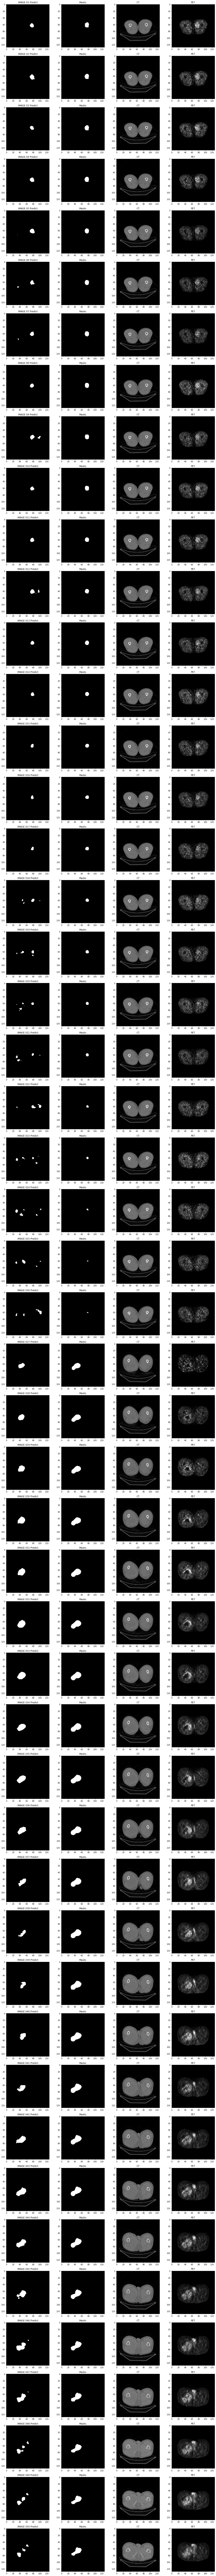

In [28]:
# visualization
p_list = range(50,100)
fig, ax = plt.subplots(nrows=len(p_list),  ncols=4, figsize=(20, 5*len(p_list)))
save_list = []
for c in range(len(p_list)):
    ax[c, 0].imshow(masks[p_list[c]][0],cmap="gray")
    save_list.append(masks[p_list[c]][0])
    ax[c, 0].set_title("IMAGE 0"+str(c+1)+" Predict")
    ax[c, 1].imshow(masks[p_list[c]][1],cmap="gray")
    ax[c, 1].set_title("Masks")
    ax[c, 2].imshow((images[p_list[c]][0]+1)*255,cmap="gray")
    ax[c, 2].set_title("CT")
    ax[c, 3].imshow((images[p_list[c]][1]+1)*255,cmap="gray")
    ax[c, 3].set_title("PET") 

In [48]:
# torch.save(model, 'model_3D Convolution.pkl')
# test_model = torch.load('model_3D Convolution.pkl')